In [1]:
import tensorflow as tf
from tensorflow import keras as keras
print(tf.__version__)

print(keras.__version__)

2.3.1
2.4.0


In [2]:
import matplotlib.pyplot as plt
import os
import sys
import numpy as np

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Flatten
from tensorflow.python.keras.layers.convolutional import Conv2D, MaxPooling2D, AveragePooling2D
from tensorflow.keras.layers import Dense, Dropout, Embedding, SimpleRNN, LSTM, Bidirectional
from tensorflow.keras.callbacks import History

The Embedding layer is defined as the first hidden layer of a network. It must specify 3 arguments:

It must specify 3 arguments:

* **input_dim**: This is the size of the vocabulary in the text data. For example, if your data is integer encoded to values between 0-10, then the size of the vocabulary would be 11 words.
* **output_dim**: This is the size of the vector space in which words will be embedded. It defines the size of the output vectors from this layer for each word. For example, it could be 32 or 100 or even larger. Test different values for your problem.
* **input_length**: This is the length of input sequences, as you would define for any input layer of a Keras model. For example, if all of your input documents are comprised of 1000 words, this would be 1000.

# Zad.

Poberz dane z konkursu http://2017.poleval.pl/index.php/tasks/ Task 2. Sentiment analysis

Pojedyńczy plik można pobrać z tąd:
https://www.dropbox.com/sh/tjq47ybybgnrbel/AAAVbp0UkQTAbKWVMIi5mtHpa?dl=0


In [3]:
file_with_filtered_embeddings = "Dane/data_poleval/embeddings.txt"

words2ids = {}
embeddings = []

embeddings.append(np.zeros(300)) # rezerwujemy embeddingi na paddin i nieznane slowa
embeddings.append(np.zeros(300))

i = 0
with open(file_with_filtered_embeddings,"r", encoding="utf8")as f:
    for line in f:
        toks = line.split(" ")
        word = toks[0]
        embeddings.append(np.array([float(x) for x in toks[1:]]))
        words2ids[word] = i+2 # +3 - przesuniecie po to zeby specjalne embeddingi byly na pozycji 0 i 1
        i = i + 1


embeddings = np.array(embeddings)
print(embeddings.shape)

(5000, 300)


In [4]:
words2ids["Słodkawy"]

2731

In [5]:
embeddings[words2ids["Słodkawy"]]

array([ 0.0695675 , -0.0123177 ,  0.0190564 ,  0.0205853 , -0.0586069 ,
        0.123962  , -0.0113998 ,  0.0486168 , -0.0593128 ,  0.0244056 ,
        0.00806909, -0.0123139 ,  0.0318254 ,  0.0375928 ,  0.0488764 ,
       -0.0311151 , -0.0571845 ,  0.00886492, -0.023981  , -0.0729585 ,
        0.00780728, -0.0103228 ,  0.0451543 , -0.00375595, -0.01016   ,
        0.0157066 ,  0.0933215 ,  0.00742586,  0.0662036 ,  0.0147866 ,
       -0.0326982 , -0.105277  ,  0.0939024 , -0.141137  , -0.0390246 ,
        0.0307554 , -0.124878  ,  0.092467  , -0.0449775 ,  0.0278756 ,
        0.0120974 ,  0.0402319 , -0.0602183 ,  0.117348  , -0.0286395 ,
        0.0226578 , -0.0100841 ,  0.0928551 ,  0.0676152 , -0.0280563 ,
        0.0516412 ,  0.0899037 , -0.0634045 ,  0.0149937 , -0.0472655 ,
       -0.0638853 , -0.00977132, -0.0440674 ,  0.00945409, -0.0873957 ,
        0.0113474 ,  0.00536351,  0.0406797 ,  0.051127  ,  0.0194782 ,
        0.00793247,  0.00938793,  0.0813627 , -0.0323478 ,  0.00

In [6]:
from tensorflow.keras.preprocessing import sequence as seq
def load_and_transform_data_to_phrases(labels, parents, tokens, words2ids):

    """
    Dokumentacja
    """
    

    transform_label = {'-1':0, '0':1, '1':2}
    
    l = open(labels, "r", encoding="utf8")
    labels = [[transform_label[y] for y in x.split()] for x in l.readlines()] 
    l.close()

    p = open(parents,"r", encoding="utf8")
    parents = [[int(y) for y in x.split()] for x in p.readlines()]
    p.close()

    t = open(tokens,"r", encoding="utf8")
    tokens = [x.split() for x in t.readlines()]
    t.close()
    
    k = 0
    result = []
    
    for labels_i,parents_i,tokens_i in zip(labels,parents,tokens):
        
        k = k + 1
         
        s = []
        for i in range(len(tokens_i)):
            s.append([i,int(parents_i[i]),labels_i[i],tokens_i[i]])


        if len(s) == 1: #przypadek gdy fraza sklada sie z jednego tokena

            result.append((\
                                  tokens[0],
                                  np.array([words2ids.get(tokens[0], 1)]),\
                                  np.array(labels_i[0]) \
                              ))    
                           
        else: 
            
            for i in range(len(s)): 
                children = []
                for j in range(len(s)):
                    if s[j][1] == i+1:
                        children.append(s[j][0])
                s[i].append(children)

                
            words = [x[0] for x in s]
            children = [x[4] for x in s]
            tokens = [x[3] for x in s]
            labels_in_batch = [x[2] for x in s]
        
            phrases = [[k] for k in range(len(children))]
            for i in range(len(children)):
                for e in phrases[i]:
                    phrases[i].extend(children[e])
           
            phrases = [ np.sort(x) for x in phrases]
          
            phrases = list(zip([np.array(tokens_i)[x] for x in phrases],
                               [np.array([words2ids.get(t,1) for t in tokens_i])[x] for x in phrases],
                               labels_i))

            result.extend(phrases)
           
    return result


In [7]:
train_data = load_and_transform_data_to_phrases("Dane/data_poleval/training-treebank/rev_labels.txt", "Dane/data_poleval/training-treebank/rev_parents.txt","Dane/data_poleval/training-treebank/rev_sentence.txt",words2ids)
test_data = load_and_transform_data_to_phrases("Dane/data_poleval/poleval_test/gold_labels", "Dane/data_poleval/poleval_test/polevaltest_parents.txt","Dane/data_poleval/poleval_test/polevaltest_sentence.txt",words2ids) 

In [9]:
from tensorflow.python.keras.utils import np_utils
from tensorflow.keras.preprocessing.sequence import pad_sequences

lengths1 = [len(x[0]) for x in train_data]
lengths2 = [len(x[0]) for x in test_data]
max_len = max(lengths1 + lengths2)

x_train = np.array([x[1] for x in train_data])
x_test = np.array([x[1] for x in test_data])

y_train = np.array([x[2] for x in train_data])
y_test = np.array([x[2] for x in test_data])

y_train = np_utils.to_categorical(y_train)
y_test = np_utils.to_categorical(y_test)

X_train = pad_sequences(x_train, maxlen=max_len)
X_test = pad_sequences(x_test, maxlen=max_len)

In [10]:
print(y_train.shape)
X_train

(9510, 3)


array([[   0,    0,    0, ...,    0,    0, 2731],
       [   0,    0,    0, ..., 1465,  515,    1],
       [   0,    0,    0, ...,    0,    0, 1465],
       ...,
       [   0,    0,    0, ...,    0,    0, 2397],
       [   0,    0,    0, ...,    0, 2397, 2903],
       [   0,    0,    0, ...,    0,    0,    1]])

In [11]:
history_1 = History()
model = Sequential()
model.add(Embedding(5000, 300, input_length=max_len))
model.add(Flatten())
model.add(Dense(3, activation='softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 40, 300)           1500000   
_________________________________________________________________
flatten (Flatten)            (None, 12000)             0         
_________________________________________________________________
dense (Dense)                (None, 3)                 36003     
Total params: 1,536,003
Trainable params: 1,536,003
Non-trainable params: 0
_________________________________________________________________


In [12]:
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["categorical_accuracy"])
model.fit(X_train, y_train, epochs=100, validation_split=0.2, callbacks=[history_1])
# model.evaluate(x_test, y_test)

Epoch 1/100
238/238 [==============================] - 7s 30ms/step - loss: 0.4870 - categorical_accuracy: 0.8143 - val_loss: 0.4710 - val_categorical_accuracy: 0.8197
Epoch 2/100
238/238 [==============================] - 8s 32ms/step - loss: 0.2744 - categorical_accuracy: 0.8996 - val_loss: 0.4372 - val_categorical_accuracy: 0.8297
Epoch 3/100
238/238 [==============================] - 7s 30ms/step - loss: 0.1608 - categorical_accuracy: 0.9473 - val_loss: 0.4482 - val_categorical_accuracy: 0.8360
Epoch 4/100
238/238 [==============================] - 7s 30ms/step - loss: 0.0987 - categorical_accuracy: 0.9691 - val_loss: 0.4495 - val_categorical_accuracy: 0.8433
Epoch 5/100
238/238 [==============================] - 7s 29ms/step - loss: 0.0671 - categorical_accuracy: 0.9787 - val_loss: 0.4869 - val_categorical_accuracy: 0.8391
Epoch 6/100
238/238 [==============================] - 7s 31ms/step - loss: 0.0488 - categorical_accuracy: 0.9846 - val_loss: 0.5022 - val_categorical_accuracy:

238/238 [==============================] - 7s 30ms/step - loss: 0.0089 - categorical_accuracy: 0.9967 - val_loss: 1.1169 - val_categorical_accuracy: 0.8360
Epoch 50/100
238/238 [==============================] - 7s 29ms/step - loss: 0.0108 - categorical_accuracy: 0.9955 - val_loss: 1.1162 - val_categorical_accuracy: 0.8417
Epoch 51/100
238/238 [==============================] - 7s 30ms/step - loss: 0.0093 - categorical_accuracy: 0.9961 - val_loss: 1.1101 - val_categorical_accuracy: 0.8396
Epoch 52/100
238/238 [==============================] - 7s 30ms/step - loss: 0.0093 - categorical_accuracy: 0.9967 - val_loss: 1.1061 - val_categorical_accuracy: 0.8365
Epoch 53/100
238/238 [==============================] - 7s 30ms/step - loss: 0.0092 - categorical_accuracy: 0.9967 - val_loss: 1.1556 - val_categorical_accuracy: 0.8412
Epoch 54/100
238/238 [==============================] - 7s 29ms/step - loss: 0.0098 - categorical_accuracy: 0.9963 - val_loss: 1.1550 - val_categorical_accuracy: 0.8386

238/238 [==============================] - 7s 30ms/step - loss: 0.0086 - categorical_accuracy: 0.9970 - val_loss: 1.4698 - val_categorical_accuracy: 0.8307
Epoch 98/100
238/238 [==============================] - 7s 29ms/step - loss: 0.0080 - categorical_accuracy: 0.9971 - val_loss: 1.4529 - val_categorical_accuracy: 0.8275
Epoch 99/100
238/238 [==============================] - 8s 32ms/step - loss: 0.0085 - categorical_accuracy: 0.9965 - val_loss: 1.4546 - val_categorical_accuracy: 0.8307
Epoch 100/100
238/238 [==============================] - 7s 30ms/step - loss: 0.0085 - categorical_accuracy: 0.9963 - val_loss: 1.4419 - val_categorical_accuracy: 0.8291


In [13]:
# evaluate the model
loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
print('Accuracy: %f' % (accuracy))

Accuracy: 0.744799


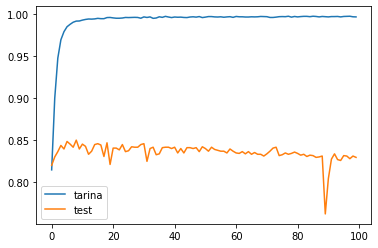

In [14]:
plt.plot(history_1.history['categorical_accuracy'], label = "tarina")
plt.plot(history_1.history['val_categorical_accuracy'], label = "test")


plt.legend()
plt.show()

# Zad
Użyj Pretrain embedding


In [15]:
history_2 = History()
model = Sequential()
model.add(Embedding(5000, 300,
                   input_length=max_len,
                  weights=[embeddings],
                  trainable=False))
model.add(Flatten())
model.add(Dense(3, activation='softmax'))
model.summary()
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["categorical_accuracy"])
model.fit(X_train, y_train, epochs=100, validation_split=0.2, callbacks=[history_2])

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 40, 300)           1500000   
_________________________________________________________________
flatten_1 (Flatten)          (None, 12000)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 36003     
Total params: 1,536,003
Trainable params: 36,003
Non-trainable params: 1,500,000
_________________________________________________________________
Epoch 1/100
238/238 [==============================] - 1s 4ms/step - loss: 0.6540 - categorical_accuracy: 0.8134 - val_loss: 0.7208 - val_categorical_accuracy: 0.8218
Epoch 2/100
238/238 [==============================] - 1s 3ms/step - loss: 0.4196 - categorical_accuracy: 0.8956 - val_loss: 0.6991 - val_categorical_accuracy: 0.8281
Epoch 3/100
238/238 [==============

238/238 [==============================] - 1s 3ms/step - loss: 0.0701 - categorical_accuracy: 0.9783 - val_loss: 1.3540 - val_categorical_accuracy: 0.8533
Epoch 46/100
238/238 [==============================] - 1s 3ms/step - loss: 0.0674 - categorical_accuracy: 0.9783 - val_loss: 1.4203 - val_categorical_accuracy: 0.8449
Epoch 47/100
238/238 [==============================] - 1s 3ms/step - loss: 0.0697 - categorical_accuracy: 0.9778 - val_loss: 1.4015 - val_categorical_accuracy: 0.8460
Epoch 48/100
238/238 [==============================] - 1s 3ms/step - loss: 0.0685 - categorical_accuracy: 0.9786 - val_loss: 1.4164 - val_categorical_accuracy: 0.8491
Epoch 49/100
238/238 [==============================] - 1s 3ms/step - loss: 0.0684 - categorical_accuracy: 0.9783 - val_loss: 1.4318 - val_categorical_accuracy: 0.8465
Epoch 50/100
238/238 [==============================] - 1s 4ms/step - loss: 0.0683 - categorical_accuracy: 0.9771 - val_loss: 1.4149 - val_categorical_accuracy: 0.8460
Epoch

238/238 [==============================] - 1s 4ms/step - loss: 0.0574 - categorical_accuracy: 0.9832 - val_loss: 1.9666 - val_categorical_accuracy: 0.8444
Epoch 94/100
238/238 [==============================] - 1s 3ms/step - loss: 0.0561 - categorical_accuracy: 0.9824 - val_loss: 1.9377 - val_categorical_accuracy: 0.8407
Epoch 95/100
238/238 [==============================] - 1s 3ms/step - loss: 0.0582 - categorical_accuracy: 0.9819 - val_loss: 1.9791 - val_categorical_accuracy: 0.8444
Epoch 96/100
238/238 [==============================] - 1s 4ms/step - loss: 0.0573 - categorical_accuracy: 0.9816 - val_loss: 1.9498 - val_categorical_accuracy: 0.8428
Epoch 97/100
238/238 [==============================] - 1s 3ms/step - loss: 0.0576 - categorical_accuracy: 0.9830 - val_loss: 1.9809 - val_categorical_accuracy: 0.8417
Epoch 98/100
238/238 [==============================] - 1s 3ms/step - loss: 0.0538 - categorical_accuracy: 0.9816 - val_loss: 1.9805 - val_categorical_accuracy: 0.8449
Epoch

In [16]:
# evaluate the model
loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
print('Accuracy: %f' % (accuracy))

Accuracy: 0.754309


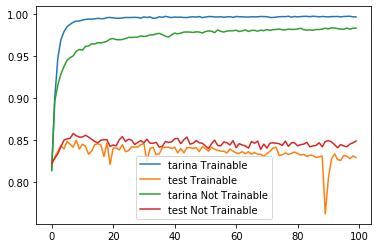

In [17]:
plt.plot(history_1.history['categorical_accuracy'], label = "tarina Trainable")
plt.plot(history_1.history['val_categorical_accuracy'], label = "test Trainable")

plt.plot(history_2.history['categorical_accuracy'], label = "tarina Not Trainable")
plt.plot(history_2.history['val_categorical_accuracy'], label = "test Not Trainable")


plt.legend()
plt.show()

# Zad
Użyj architektury
```python
model = Sequential()
model.add(Embedding(5000, 300,
                   input_length=max_len,
                  weights=[embeddings],
                  trainable=False))
model.add(LSTM(10))
model.add(Dense(3, activation='softmax'))
model.summary()
```

# Zad
Użyj architektury
```python
model = Sequential()
model.add(Embedding(5000, 300,
                   input_length=max_len,
                  weights=[embeddings],
                  trainable=False))
model.add(Conv1D(50,3))
model.add(LSTM(10))
model.add(Dense(3, activation='softmax'))
model.summary()
```

Co dokładnie robi 

```python
from keras.layers.convolutional import Conv1D
```

# Zad
Użyj architektury

```python
model = Sequential()
model.add(Embedding(5000, 300,
                   input_length=max_len,
                  weights=[embeddings],
                  trainable=False))
model.add(TimeDistributed(Dense(10,activation="tanh")))
model.add(LSTM(10))
model.add(Dense(3, activation='softmax'))
model.summary()
```

Co dokładnie robi 

```python
from keras.layers import TimeDistributed
```
